In [1]:
import pandas as pd
import torch
from tailnflows.experiment_utils import load_experiment_data

torch.set_default_dtype(torch.float64)
torch.manual_seed(1000)

In [3]:
experiment_data, models = load_experiment_data()
experiment_data = experiment_data[experiment_data['target'] == 'neals_funnel']
experiment_data.head()

,seed,grad_clip,safe_grad,lr,target,target_kwargs,opt_steps,batch_size,model,model_kwargs,run_time,record_interval,path,dim
0,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,ATAF,{'tail_init': -10.0},2023-06-05_12-13,1000,/home/th17628/projects/tailnflows/experiment_o...,22
1,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,TTF,{'tail_init': -10.0},2023-06-05_12-11,1000,/home/th17628/projects/tailnflows/experiment_o...,22
2,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,TTF,{'tail_init': 1.0},2023-06-05_12-11,1000,/home/th17628/projects/tailnflows/experiment_o...,22
3,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,ATAF,{'tail_init': 1.0},2023-06-05_12-12,1000,/home/th17628/projects/tailnflows/experiment_o...,22
4,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,ATAF,{'tail_init': -10.0},2023-06-05_12-12,1000,/home/th17628/projects/tailnflows/experiment_o...,22


In [5]:
from tailnflows.metrics import ess, psis_index
from tailnflows.targets import targets
import numpy as np
from tqdm import tqdm

metric_df = {'ix': [], 'ess': [], 'psis_k': []}

loop = tqdm(experiment_data.index)
for ix in loop:
    row = experiment_data.iloc[ix]
    target, dim, _ = targets[row['target']](row['target_kwargs'])
    sample_and_log_prob, model = models[ix]
    metric_df['ix'].append(ix)
    try:
        final_ess = ess(sample_and_log_prob, target, 10000)
        metric_df['ess'].append(final_ess.detach().numpy())
    except:
        metric_df['ess'].append(np.nan)

    try:
        metric_df['psis_k'].append(psis_index(sample_and_log_prob, target, 10000))
    except:
        metric_df['psis_k'].append(np.nan)

metric_df = pd.DataFrame(metric_df).set_index('ix')
metric_experiment_data = experiment_data.join(metric_df)

100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


In [6]:
def expand(experiment_data):
    experiment_data = experiment_data.join(experiment_data['target_kwargs'].apply(pd.Series))
    experiment_data = experiment_data.join(experiment_data['model_kwargs'].apply(pd.Series))
    return experiment_data

In [7]:
expanded_experiment_data = expand(metric_experiment_data)
expanded_experiment_data.head()

,seed,grad_clip,safe_grad,lr,target,target_kwargs,opt_steps,batch_size,model,model_kwargs,...,record_interval,path,dim,ess,psis_k,scale_model_name,d_nuisance,df_nuisance,heavy_nuisance,tail_init
0,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,ATAF,{'tail_init': -10.0},...,1000,/home/th17628/projects/tailnflows/experiment_o...,22,0.0011548074751251416,1.138689,funnel,20,1.0,True,-10.0
1,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,TTF,{'tail_init': -10.0},...,1000,/home/th17628/projects/tailnflows/experiment_o...,22,0.05141949763922206,0.820690,funnel,20,1.0,True,-10.0
2,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,TTF,{'tail_init': 1.0},...,1000,/home/th17628/projects/tailnflows/experiment_o...,22,0.002756784167483573,0.965369,funnel,20,1.0,True,1.0
3,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,ATAF,{'tail_init': 1.0},...,1000,/home/th17628/projects/tailnflows/experiment_o...,22,0.0005033941076721695,1.199732,funnel,20,1.0,True,1.0
4,5,False,False,0.001,neals_funnel,"{'scale_model_name': 'funnel', 'd_nuisance': 2...",2000,100,ATAF,{'tail_init': -10.0},...,1000,/home/th17628/projects/tailnflows/experiment_o...,22,0.0005624525441424179,1.312929,funnel,20,1.0,True,-10.0


In [8]:
expanded_experiment_data['df_nuisance'] = expanded_experiment_data['df_nuisance'].fillna(1000.) # update to non-na for easy processing


In [11]:
# renamed = expanded_experiment_data.rename({'df_nuisance': '$\\nu$', 'd_nuisance': '$d$', 'model_name': 'model'}, axis=1)
# mean_ess = renamed.groupby(['$\\nu$', '$d$', 'model'])[['ess', 'psis_k']].agg(['mean'])
mean_ess = expanded_experiment_data.groupby(['df_nuisance', 'd_nuisance', 'model'])[['ess', 'psis_k']].agg(['mean'])

def s(col):
    if col.name[0] == 'psis_k':
        return (col < 0.7).map({
            True: 'textbf:--rwrap;',
            False: '',
        })
    else:
        means = col.groupby(level=0).transform('mean')
        return (col > means).map({
            True: 'textbf:--rwrap;',
            False: '',
        })
    
styled_mean_ess = mean_ess.style.format(precision=2).apply(s).set_table_styles([
    {'selector': 'toprule', 'props': ':toprule;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
    {'selector': 'midrule', 'props': ':hline;'},
], overwrite=False)

print(styled_mean_ess.to_latex())

\begin{tabular}{lllrr}
\toprule
 &  &  & ess & psis_k \\
 &  &  & mean & mean \\
df_nuisance & d_nuisance & model &  &  \\
\hline
\multirow[c]{2}{*}{1.000000} & \multirow[c]{2}{*}{20} & ATAF & 0.00 & 1.22 \\
 &  & TTF & \textbf{0.02} & 0.91 \\
\hline
\end{tabular}



In [12]:
mean_ess

ess    psis_k
                                 mean      mean
df_nuisance d_nuisance model                   
1.0         20         ATAF   0.00074  1.217117
                       TTF    0.02092  0.906596

### Plotting

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.ioff()
for ix, _experiment_data in experiment_data.iterrows():
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_train_track(ax, _experiment_data)
    fig.savefig(f'{_experiment_data["path"]}/train_track.png', facecolor='white')
    plt.close(fig)

    # fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # plot_extreme_track(ax, _experiment_data)
    # fig.savefig(f'{_experiment_data["path"]}/extremes_track.png', facecolor='white')
    # plt.close(fig)

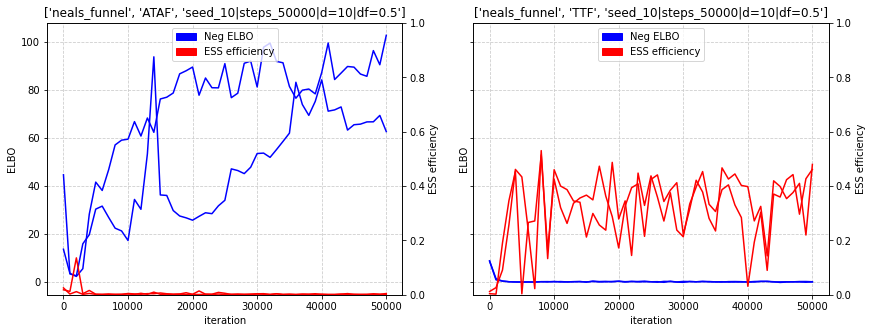

In [78]:
import numpy as np
import matplotlib.pyplot as plt

target_data = experiment_data[experiment_data['df_nuisance'] == .5]
# target_data = e_experiment_data
models = {
    name: ix 
    for ix, name in enumerate(target_data['model_name'].unique())
}

fig, axarr = plt.subplots(1, len(models), figsize=(7 * len(models), 5), sharey=True)
ess_axarr = [ax.twinx() for ax in axarr]

for ix, row in target_data.iterrows():
    plt_ix = models[row['model_name']]
    plot_train_track(axarr[plt_ix], row, plot=True)
    plot_ess_track(ess_axarr[plt_ix], row, plot=True)

# axarr[0].set_ylim([-1., 1])
plt.show()

In [71]:
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator

def plot_train_track(ax, experiment_data, plot=False, plot_kwargs={}):
    path = experiment_data['path']
    with open(f'{path}/training_data.npy', 'rb') as f:
        training_data = np.load(f, allow_pickle=True)[()]

    ax.legend(handles=[
        mpatches.Patch(color='blue', label='Neg ELBO'),
        mpatches.Patch(color='red', label='ESS efficiency'),
    ], loc='upper center')
    ax.set_xlabel('iteration')

    losses = training_data['losses']

    if plot:
        ax.plot(training_data['iterations'], losses, c='blue', **plot_kwargs)
    else:
        ax.scatter(training_data['iterations'], training_data['losses'], c='blue', marker='x', **plot_kwargs)
    
    ax.set_ylabel('ELBO')
    ax.xaxis.set_major_locator(MultipleLocator(10000))
    ax.grid(which='major', color='#CCCCCC', linestyle='--')

    ax.set_title(path.split('/')[1:])

In [72]:
def plot_ess_track(ax, experiment_data, plot=False, plot_kwargs={}):
    
    ax.set_ylim(0., 1.)
    ax.set_ylabel('ESS efficiency')
    path = experiment_data['path']
    with open(f'{path}/training_data.npy', 'rb') as f:
        training_data = np.load(f, allow_pickle=True)[()]

    if plot:
        ax.plot(training_data['iterations'], training_data['esses'], c='red', **plot_kwargs)
    else:
        ax.scatter(training_data['iterations'], training_data['esses'], c='red', **plot_kwargs)